In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import grid_evaluate
from sklearn.neural_network import MLPClassifier


#Load the saved CSVs
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')


#Squeeze to make them series
y_train = y_train.squeeze()
y_test = y_test.squeeze()


#Define the base model
base_clf = MLPClassifier(
    max_iter=1000,
    random_state=42
)


param_grid = {

    'hidden_layer_sizes': [(15,), (20,), (15,15)],
    'activation':         ['relu', 'tanh'],
    'alpha':              [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #L2 penalty (weight decay)
    'learning_rate_init': [1e-3, 1e-2],
}


results_nn = grid_evaluate(
    estimator  = base_clf,
    param_grid = param_grid,
    X_train    = X_train,
    X_test     = X_test,
    y_train    = y_train,
    y_test     = y_test
)

#drop unnecessary columns (not modified in neural network model)
results_nn = results_nn.drop(
    columns=['feature_method','degree','n_components','gamma'],
    errors='ignore'   # won’t error out if any are already missing
)

#Inspect best model by F1
best_nn = results_nn.sort_values('f1_test', ascending=False)
print(best_nn.iloc[0])
print(best_nn)


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 5 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 10 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 15 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 20 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 25 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 30 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 35 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 40 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 45 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 50 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 55 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 60 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 65 parameter combinations...


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluated 70 parameter combinations...
accuracy_test            0.728
accuracy_train        0.973226
precision_test        0.448276
recall_test           0.419355
f1_test               0.433333
f1_train              0.942529
precision_train       0.942529
recall_train          0.942529
activation                relu
alpha                    0.001
hidden_layer_sizes    (15, 15)
learning_rate_init        0.01
Name: 23, dtype: object
    accuracy_test  accuracy_train  precision_test  recall_test   f1_test  \
23          0.728        0.973226        0.448276     0.419355  0.433333   
28          0.724        0.961178        0.438596     0.403226  0.420168   
22          0.728        0.963855        0.444444     0.387097  0.413793   
10          0.728        0.963855        0.444444     0.387097  0.413793   
4           0.724        0.959839        0.436364     0.387097  0.410256   
..            ...             ...             ...          ...       ...   
25          0.644        0.946452

/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


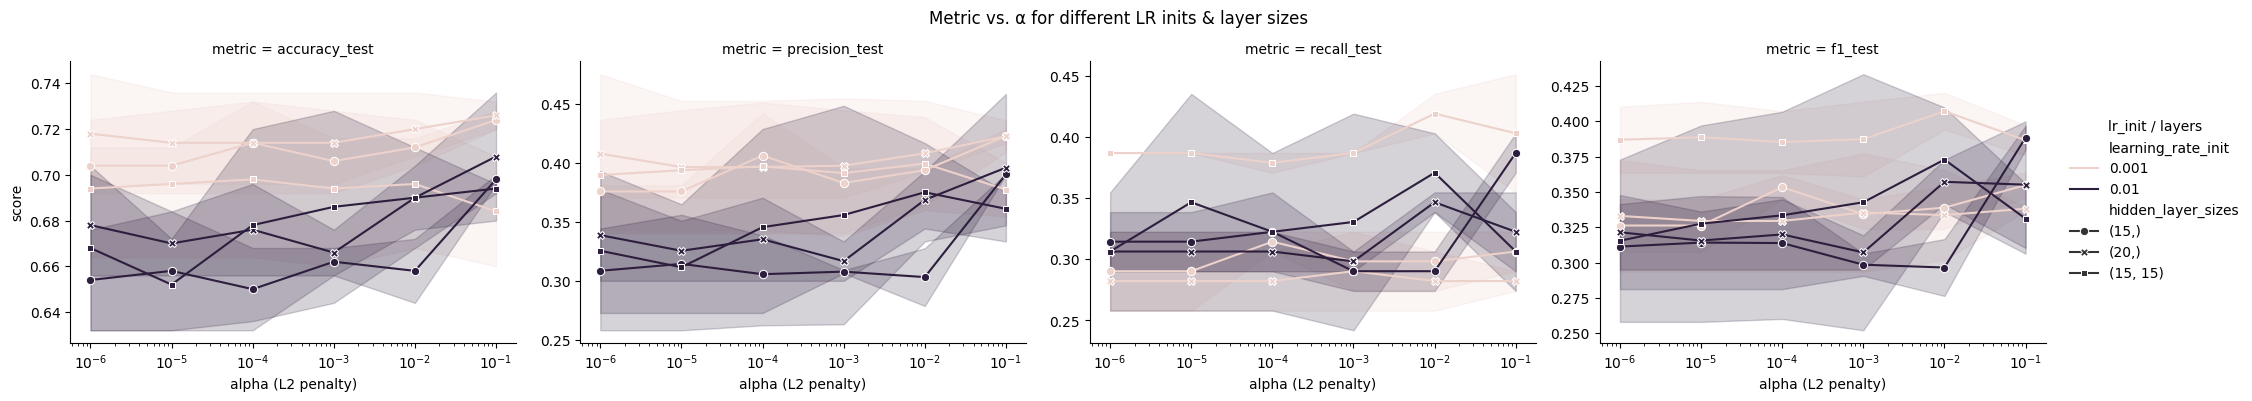

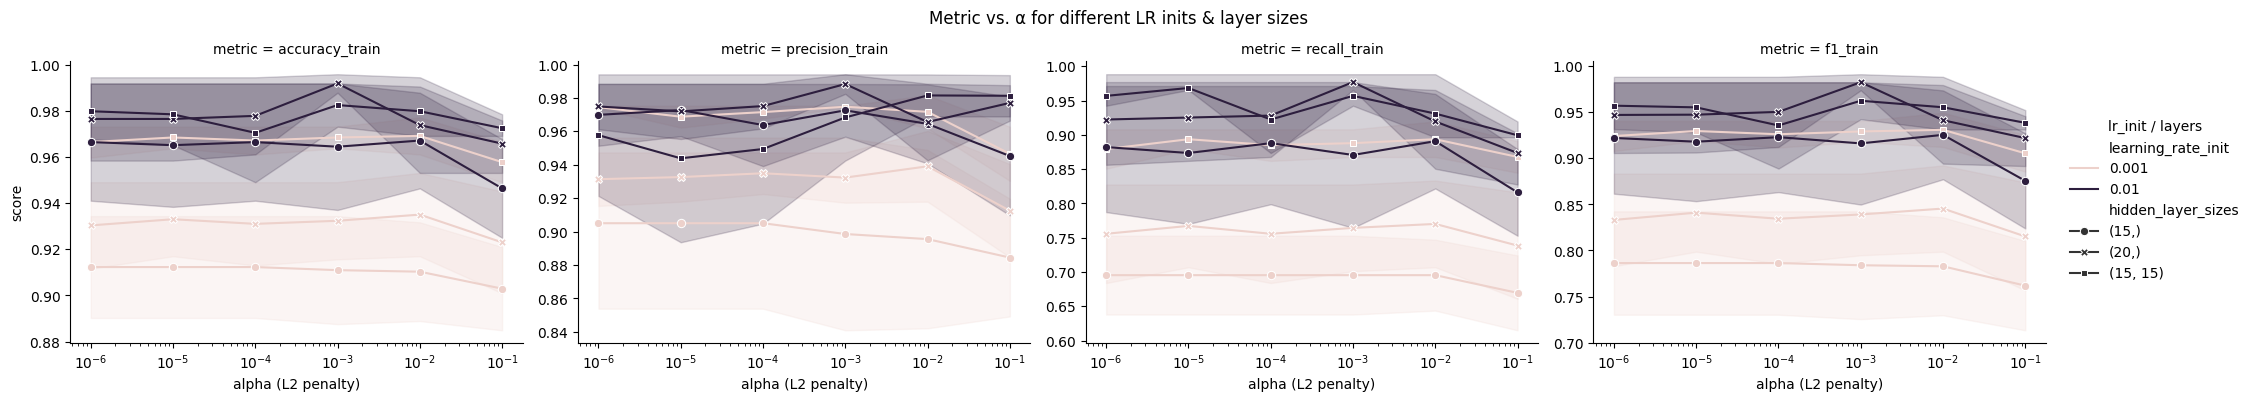

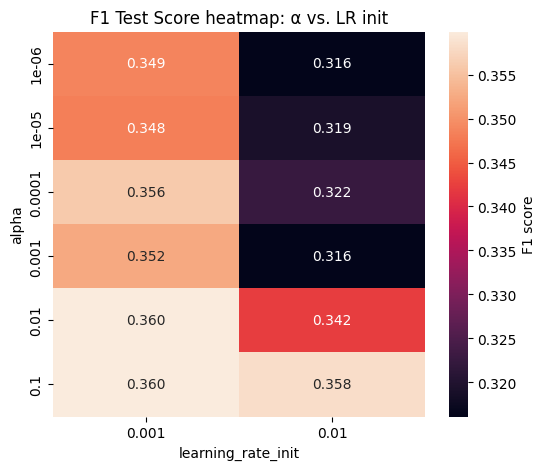

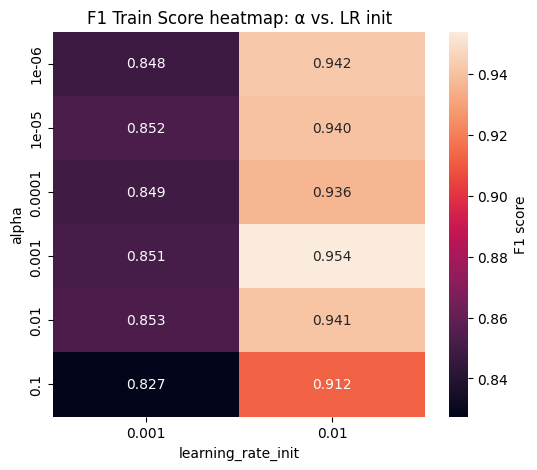

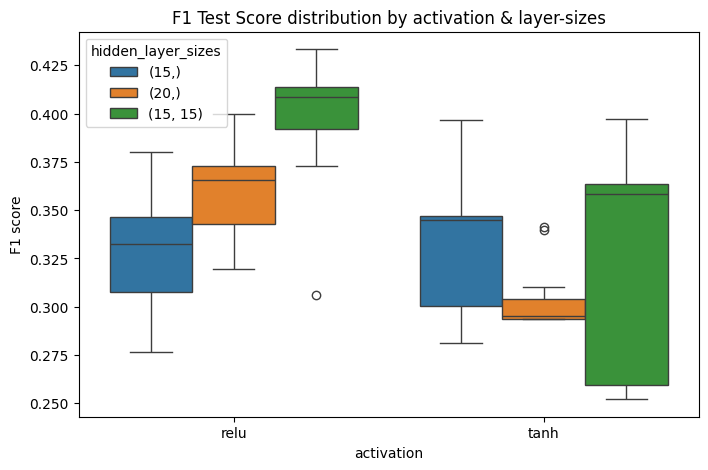

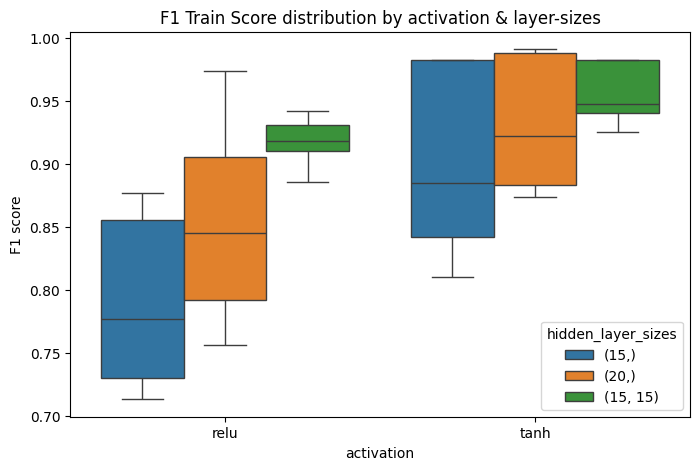

In [6]:

df = results_nn.reset_index(drop=True)


#reshapping df for easier plotting
metrics = ['accuracy_test','precision_test','recall_test','f1_test']
df_long_test = df.melt(
    id_vars=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)


#using sns to visualize the results
g = sns.FacetGrid(
    df_long_test, 
    col='metric', 
    sharey=False, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.lineplot,
    x='alpha', 
    y='score',
    hue='learning_rate_init',
    style='hidden_layer_sizes',
    markers=True,
    dashes=False
)

g.set(xscale='log') #log scale to visualize alpha better
g.add_legend(title='lr_init / layers')
g.set_axis_labels('alpha (L2 penalty)','score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Metric vs. α for different LR inits & layer sizes')
plt.show()

metrics = ['accuracy_train','precision_train','recall_train','f1_train']
df_long_train = df.melt(
    id_vars=['hidden_layer_sizes','activation','alpha','learning_rate_init'],
    value_vars=metrics,
    var_name='metric',
    value_name='score'
)

#using sns to visualize the results
g = sns.FacetGrid(
    df_long_train, 
    col='metric', 
    sharey=False, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.lineplot,
    x='alpha', 
    y='score',
    hue='learning_rate_init',
    style='hidden_layer_sizes',
    markers=True,
    dashes=False
)

g.set(xscale='log') #log scale to visualize alpha better
g.add_legend(title='lr_init / layers')
g.set_axis_labels('alpha (L2 penalty)','score')
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Metric vs. α for different LR inits & layer sizes')
plt.show()


#heatmap of F1-score over (alpha, learning_rate_init)

pivot_f1 = df.pivot_table(
    index='alpha', 
    columns='learning_rate_init', 
    values='f1_test'
)

plt.figure(figsize=(6,5))
sns.heatmap(
    pivot_f1, 
    annot=True, 
    fmt=".3f", 
    cbar_kws={'label':'F1 score'}
)
plt.title('F1 Test Score heatmap: α vs. LR init')
plt.xlabel('learning_rate_init')
plt.ylabel('alpha')
plt.show()

#train
pivot_f1 = df.pivot_table(
    index='alpha', 
    columns='learning_rate_init', 
    values='f1_train'
)

plt.figure(figsize=(6,5))
sns.heatmap(
    pivot_f1, 
    annot=True, 
    fmt=".3f", 
    cbar_kws={'label':'F1 score'}
)
plt.title('F1 Train Score heatmap: α vs. LR init')
plt.xlabel('learning_rate_init')
plt.ylabel('alpha')
plt.show()

#activation comparison
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_long_test[df_long_test.metric=='f1_test'],
    x='activation',
    y='score',
    hue='hidden_layer_sizes'
)
plt.title('F1 Test Score distribution by activation & layer-sizes')
plt.ylabel('F1 score')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(
    data=df_long_train[df_long_train.metric=='f1_train'],
    x='activation',
    y='score',
    hue='hidden_layer_sizes'
)
plt.title('F1 Train Score distribution by activation & layer-sizes')
plt.ylabel('F1 score')
plt.show()

In [7]:
best_nn.to_csv('nn_results.csv', index=False)
print("Saved results to nn_results.csv")

Saved results to nn_results.csv
